# Advanced Feature Engineering — IEEE-CIS Fraud Detection

This notebook is a **data-science reference guide** to feature engineering
for tabular fraud detection. It demonstrates every major technique category
with concrete implementations and explains *why* each technique works.

## Dataset
The [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection)
dataset consists of:
- **Transaction table** — ~590 k rows × 394 columns
  (TransactionDT, TransactionAmt, ProductCD, card1–6, addr, C/D/M/V features)
- **Identity table** — ~144 k rows × 41 columns
  (DeviceType, DeviceInfo, id_01–id_38)

Because the dataset requires Kaggle authentication, this notebook uses a
**synthetic replica** (`load_synthetic_ieee`) that mirrors the real dataset's
schema, missing-value patterns, cardinalities, and class imbalance (~3.5 % fraud).
The same code runs unchanged on the real CSV files — just swap the loader.

## Techniques covered
| Section | Technique |
|---------|-----------|
| §3 | Missingness analysis & heuristic imputation |
| §4 | Frequency encoding & smoothed target (mean) encoding |
| §5 | Hand-crafted interaction features |
| §6 | Entity-level aggregation (group statistics) |
| §7 | Temporal feature extraction + cyclical sin/cos encoding |
| §8 | PCA compression of correlated V-feature blocks |
| §9 | Feature selection: variance, correlation pruning, permutation importance |
| §10 | Baseline vs. engineered-features model lift |


## 1. Setup & Imports

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))   # allow notebook to find the package

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# ── project helpers ──────────────────────────────────────────────────────────
from feature_engineering.preprocessing import (
    load_synthetic_ieee,
    reduce_mem_usage,
    summarise_missing,
    impute_by_type,
)
from feature_engineering.encoders import TargetEncoder, FrequencyEncoder
from feature_engineering.aggregations import GroupAggregator
from feature_engineering.temporal import extract_temporal_features, extract_email_features
from feature_engineering.selection import (
    drop_high_correlation,
    variance_threshold_select,
    importance_select,
    pca_compress,
)
from feature_engineering.utils import (
    plot_missing,
    plot_feature_importance,
    roc_comparison,
    plot_pca_explained_variance,
    evaluate_model,
)

sns.set_theme(style="whitegrid", palette="muted")
pd.set_option("display.max_columns", 60)
pd.set_option("display.float_format", "{:.4f}".format)
print("All imports OK.")


All imports OK.


## 2. Load Synthetic IEEE-CIS Data

`load_synthetic_ieee` returns two DataFrames with the exact same schema as
the Kaggle competition files.
To use the **real** data, replace the cell below with:

```python
trans    = pd.read_csv("train_transaction.csv")
identity = pd.read_csv("train_identity.csv")
```
Just make sure you have allocated enough resources to your container or environment


In [2]:
# trans, identity = load_synthetic_ieee(n_rows=150_000, seed=42)
trans    = pd.read_csv("train_transaction.csv")
identity = pd.read_csv("train_identity.csv")

print(f"Transactions : {trans.shape[0]:,} rows × {trans.shape[1]} columns")
print(f"Identity     : {identity.shape[0]:,} rows × {identity.shape[1]} columns")
print(f"\nFraud rate   : {trans['isFraud'].mean() * 100:.2f} %")
trans.head(3)


Transactions : 590,540 rows × 394 columns
Identity     : 144,233 rows × 41 columns

Fraud rate   : 3.50 %


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,...,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5000,W,13926,NaN,150.0000,discover,142.0000,credit,315.0000,87.0000,19.0000,NaN,NaN,NaN,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,2.0000,0.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,117.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0000,W,2755,404.0000,150.0000,mastercard,102.0000,credit,325.0000,87.0000,NaN,NaN,gmail.com,NaN,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0000,W,4663,490.0000,150.0000,visa,166.0000,debit,330.0000,87.0000,287.0000,NaN,outlook.com,NaN,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Merge identity on TransactionID (left join — most approaches merge here)
df = trans.merge(identity, on="TransactionID", how="left")
print(f"Merged shape : {df.shape[0]:,} rows × {df.shape[1]} columns")

# Downcast dtypes immediately to reduce RAM
df = reduce_mem_usage(df)


Merged shape : 590,540 rows × 434 columns
Memory: 2514.0 MB → 1603.3 MB  (36.2 % reduction)


## 3. Exploratory Data Analysis

Before engineering features we need to understand:
1. Class imbalance
2. Missingness patterns
3. Distribution of the key numeric columns


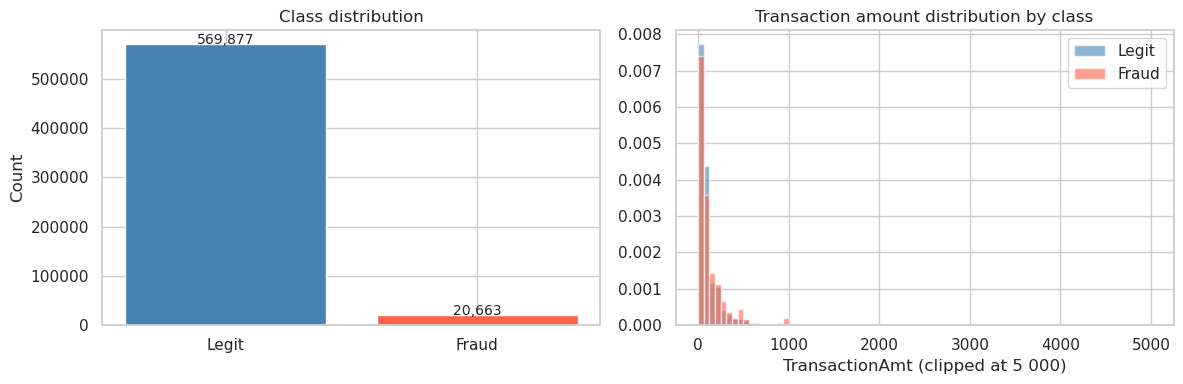

In [4]:
# ── Class imbalance ──────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

fraud_counts = df["isFraud"].value_counts()
axes[0].bar(["Legit", "Fraud"], fraud_counts.values,
            color=["steelblue", "tomato"], edgecolor="white")
axes[0].set_title("Class distribution")
axes[0].set_ylabel("Count")
for i, v in enumerate(fraud_counts.values):
    axes[0].text(i, v + 200, f"{v:,}", ha="center", fontsize=10)

# TransactionAmt distribution (log scale) by class
legit = df.loc[df["isFraud"] == 0, "TransactionAmt"].clip(upper=5000)
fraud = df.loc[df["isFraud"] == 1, "TransactionAmt"].clip(upper=5000)
axes[1].hist(legit, bins=80, alpha=0.6, label="Legit", color="steelblue", density=True)
axes[1].hist(fraud, bins=80, alpha=0.6, label="Fraud", color="tomato", density=True)
axes[1].set_xlabel("TransactionAmt (clipped at 5 000)")
axes[1].set_title("Transaction amount distribution by class")
axes[1].legend()

plt.tight_layout()
plt.show()


Top 20 columns by missingness:


,n_missing,pct_missing,dtype,n_unique,example_values
id_24,585793,99.2000,float32,12,"[11.0, 11.0, 15.0]"
id_21,585381,99.1300,float32,490,"[252.0, 252.0, 657.0]"
id_07,585385,99.1300,float32,84,"[22.0, 6.0, -1.0]"
id_25,585408,99.1300,float32,341,"[321.0, 321.0, 161.0]"
id_26,585377,99.1300,float32,95,"[184.0, 102.0, 159.0]"
id_08,585385,99.1300,float32,94,"[-34.0, -55.0, -100.0]"
id_27,585371,99.1200,object,2,"[Found, Found, Found]"
id_23,585371,99.1200,object,3,"[IP_PROXY:TRANSPARENT, IP_PROXY:TRANSPARENT, I..."
id_22,585371,99.1200,float32,25,"[14.0, 14.0, 41.0]"
dist2,552913,93.6300,float32,1751,"[30.0, 98.0, 149.0]"


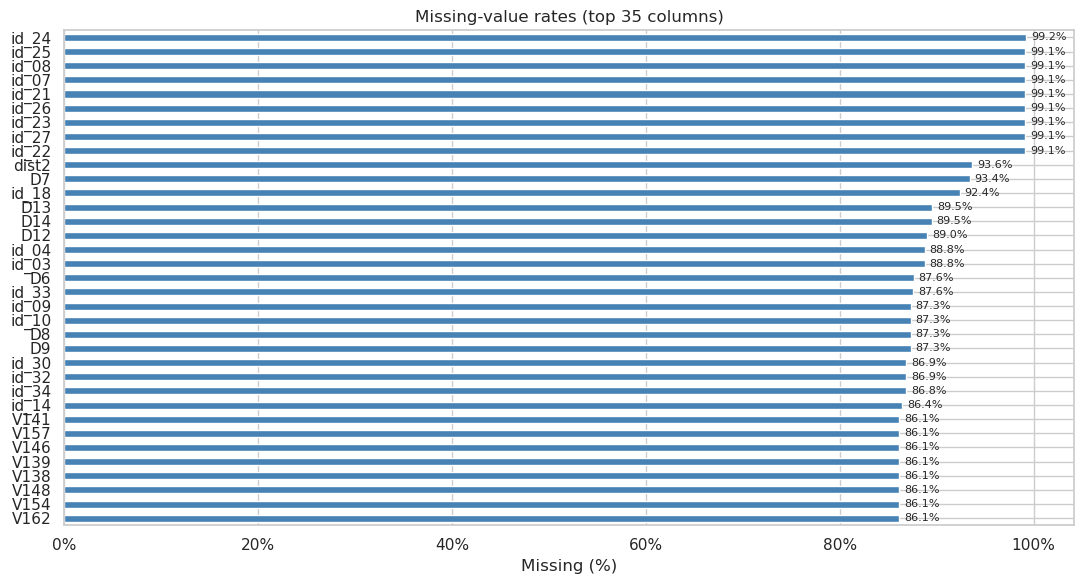

In [5]:
# ── Missingness ──────────────────────────────────────────────────────────────
# Focus on columns with at least 1 % missing for readability
miss_summary = summarise_missing(df)
print("Top 20 columns by missingness:")
display(miss_summary[miss_summary["pct_missing"] > 1].head(20))

plot_missing(df, figsize=(11, 6), max_cols=35,
             title="Missing-value rates (top 35 columns)")


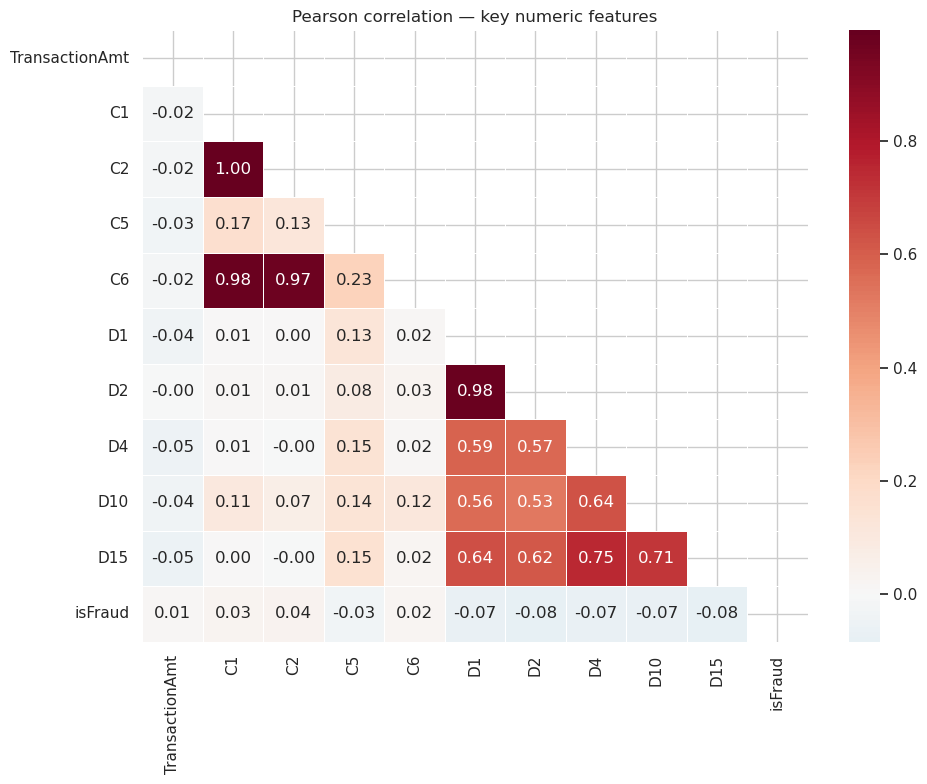

In [6]:
# ── Correlation heatmap (key numeric features only) ──────────────────────────
key_cols = ["TransactionAmt", "C1", "C2", "C5", "C6",
            "D1", "D2", "D4", "D10", "D15", "isFraud"]
key_cols = [c for c in key_cols if c in df.columns]

fig, ax = plt.subplots(figsize=(10, 8))
corr = df[key_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, ax=ax, linewidths=0.5)
ax.set_title("Pearson correlation — key numeric features")
plt.tight_layout()
plt.show()


## 4. Missing-Value Imputation

### Why is this critical for fraud detection?

The IEEE-CIS dataset contains **block-wise missingness** in the V-features:
columns within the same block are either all observed or all missing for a
given transaction. This means missingness itself is a strong signal —
a transaction with V1–V11 missing likely came from a different device
fingerprinting pathway than one with all V columns observed.

### Strategy: -999 sentinel for tree-based models

For gradient-boosted trees and random forests, the best practice is to fill
numeric NaNs with a sentinel value (`-999`) that lies far outside the
natural range. The tree can then create a split `feature < -998.5` to
distinguish missing from non-missing, effectively learning the missingness
signal automatically.

For linear models and neural networks, use **median** imputation + add a
binary `{col}_was_nan` indicator column.


In [7]:
# ── Add was_nan indicators for key partially-missing columns ─────────────────
# This preserves the missingness signal for linear models
high_miss_cols = (
    miss_summary[miss_summary["pct_missing"].between(5, 95)]
    .index[:20].tolist()
)
# Only numeric columns
high_miss_cols = [c for c in high_miss_cols
                  if c in df.select_dtypes(include=np.number).columns]

for col in high_miss_cols:
    df[f"{col}_was_nan"] = df[col].isna().astype(np.int8)

print(f"Added {len(high_miss_cols)} *_was_nan indicator columns.")

# ── Impute: -999 sentinel for trees ─────────────────────────────────────────
df = impute_by_type(df, cat_fill="Unknown", num_strategy="minus999")

print("\nRemaining missing values after imputation:",
      df.isnull().sum().sum())


Added 17 *_was_nan indicator columns.

Remaining missing values after imputation: 0


## 5. Categorical Encoding Strategies

Raw categorical columns like `card4` ("visa", "mastercard") and
`P_emaildomain` ("gmail.com", "anonymous.com") contain predictive
information that must be encoded numerically.

| Encoding | Best for | Risk |
|----------|----------|------|
| One-hot | Low-cardinality (<20 levels) | Dimensionality explosion for high-card |
| **Frequency** | High-cardinality, no target leakage | Loses within-category target info |
| **Target (mean)** | High-cardinality, strong signal | Leakage → use LOO or CV folds |
| Label | Trees only (preserves ordinality) | Ordinal assumption may be wrong |

### Frequency encoding
Replace each category with its fractional frequency.
`P_emaildomain = "gmail.com"` → 0.35 (35 % of transactions used Gmail).

### Smoothed target encoding with leave-one-out
Replace each category with the smoothed conditional fraud rate.
`P_emaildomain = "anonymous.com"` → 0.12 (12 % of anonymous.com transactions were fraud).

LOO: when encoding the *training set*, each row uses the group mean computed
**excluding itself**. This prevents the model from learning a trivially
perfect mapping `encoded_val == y`.


In [8]:
# Columns to encode
cat_cols = ["ProductCD", "card4", "card6",
            "P_emaildomain", "R_emaildomain",
            "DeviceType"]
cat_cols = [c for c in cat_cols if c in df.columns]

# ── Train / test split (before any fitting) ───────────────────────────────
# IMPORTANT: fit encoders ONLY on train to prevent leakage
y = df["isFraud"]
X = df.drop(columns=["isFraud", "TransactionID"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Train fraud rate: {y_train.mean():.4f}")
print(f"Test  fraud rate: {y_test.mean():.4f}")


Train: (472432, 449), Test: (118108, 449)
Train fraud rate: 0.0350
Test  fraud rate: 0.0350


In [9]:
# ── Frequency encoding ───────────────────────────────────────────────────────
freq_enc = FrequencyEncoder(cols=cat_cols)
X_train = freq_enc.fit_transform(X_train)   # fit on train only
X_test  = freq_enc.transform(X_test)

print("Frequency-encoded columns added:")
for col in cat_cols:
    sample = X_train[f"{col}_freq"].describe()
    print(f"  {col}_freq: mean={sample['mean']:.4f}, "
          f"min={sample['min']:.4f}, max={sample['max']:.4f}")


Frequency-encoded columns added:
  ProductCD_freq: mean=0.5746, min=0.0197, max=0.7439
  card4_freq: mean=0.5275, min=0.0026, max=0.6513
  card6_freq: mean=0.6185, min=0.0000, max=0.7448
  P_emaildomain_freq: mean=0.2169, min=0.0001, max=0.3865
  R_emaildomain_freq: mean=0.6012, min=0.0000, max=0.7667
  DeviceType_freq: mean=0.6088, min=0.0947, max=0.7609


In [10]:
# ── Target encoding (LOO on train, smoothed mean on test) ───────────────────
high_card_cols = ["P_emaildomain", "R_emaildomain", "card4", "card6", "ProductCD"]
high_card_cols = [c for c in high_card_cols if c in X_train.columns]

te_enc = TargetEncoder(cols=high_card_cols, smoothing=20, noise_level=0.01)
X_train = te_enc.fit_transform(X_train, y_train)   # LOO on train
X_test  = te_enc.transform(X_test)                  # smoothed mean on test

print("Target-encoded columns (fraud rate per category, smoothed):")
for col in high_card_cols:
    new_col = f"{col}_te"
    print(f"  {new_col}: mean={X_train[new_col].mean():.4f}, "
          f"std={X_train[new_col].std():.4f}")

# Peek at what the encoder learned for P_emaildomain
if "P_emaildomain" in te_enc._mapping:
    print("\nTop 10 P_emaildomain fraud rates (smoothed):")
    display(te_enc._mapping["P_emaildomain"].sort_values(ascending=False).head(10).to_frame("fraud_rate"))


Target-encoded columns (fraud rate per category, smoothed):
  P_emaildomain_te: mean=0.0350, std=0.0174
  R_emaildomain_te: mean=0.0350, std=0.0344
  card4_te: mean=0.0350, std=0.0110
  card6_te: mean=0.0350, std=0.0211
  ProductCD_te: mean=0.0350, std=0.0325

Top 10 P_emaildomain fraud rates (smoothed):


,fraud_rate
P_emaildomain,
protonmail.com,0.3765
mail.com,0.1804
outlook.es,0.1324
aim.com,0.1154
outlook.com,0.0918
hotmail.es,0.0591
hotmail.com,0.0529
live.com.mx,0.0509
gmail.com,0.0436


## 6. Hand-Crafted Interaction Features

Domain knowledge about fraud patterns motivates specific feature combinations.
These are features that a model *could* discover, but providing them explicitly
reduces the sample complexity required.

| Feature | Intuition |
|---------|-----------|
| `amt_div_card1_mean_amt` | Is this transaction unusually large for this card? |
| `addr_mismatch` | Purchaser address ≠ recipient address → risky |
| `is_round_amount` | Fraudsters sometimes test with round amounts |
| `log_amt` | Log-transform compresses the heavy right tail |
| `amt_cents` | Cent portion of amount (fraudsters often use .00 or .99) |


In [11]:
def add_interaction_features(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()

    # Log-amount (normalises the heavy right tail)
    X["log_TransactionAmt"] = np.log1p(X["TransactionAmt"]).astype(np.float32)

    # Cent portion of amount
    X["amt_cents"] = (X["TransactionAmt"] % 1).round(2).astype(np.float32)

    # Round-amount flag (fraudsters often use $1.00, $10.00, etc.)
    X["is_round_amount"] = (X["amt_cents"] == 0).astype(np.int8)

    # Address mismatch between addr1 and addr2 (if both present and valid)
    if "addr1" in X.columns and "addr2" in X.columns:
        valid = (X["addr1"] != -999) & (X["addr2"] != -999)
        X["addr_mismatch"] = ((X["addr1"] != X["addr2"]) & valid).astype(np.int8)

    # D1 / D2 ratio (relative recency of last transaction)
    if "D1" in X.columns and "D2" in X.columns:
        d2_safe = X["D2"].replace(-999, np.nan)
        d1_safe = X["D1"].replace(-999, np.nan)
        X["D1_D2_ratio"] = (d1_safe / (d2_safe + 1)).astype(np.float32)

    # C1 × C2 interaction (two count features that together may signal fraud)
    if "C1" in X.columns and "C2" in X.columns:
        X["C1_x_C2"] = (X["C1"] * X["C2"]).astype(np.float32)

    return X

X_train = add_interaction_features(X_train)
X_test  = add_interaction_features(X_test)

new_cols = ["log_TransactionAmt", "amt_cents", "is_round_amount",
            "addr_mismatch", "D1_D2_ratio", "C1_x_C2"]
new_cols = [c for c in new_cols if c in X_train.columns]
print(f"Added {len(new_cols)} interaction features.")
display(X_train[new_cols].describe().T)


Added 6 interaction features.


,count,mean,std,min,25%,50%,75%,max
log_TransactionAmt,472432.0000,4.3826,0.9378,0.2239,3.7874,4.2472,4.8363,10.3716
amt_cents,472432.0000,0.3789,0.4337,0.0000,0.0000,0.0000,0.9500,1.0000
is_round_amount,472432.0000,0.5173,0.4997,0.0000,0.0000,1.0000,1.0000,1.0000
addr_mismatch,472432.0000,0.8884,0.3149,0.0000,1.0000,1.0000,1.0000,1.0000
D1_D2_ratio,247635.0000,1.3884,8.7195,0.0000,0.9667,0.9916,0.9972,629.0000
C1_x_C2,472432.0000,20406.6426,525318.3125,0.0000,1.0000,2.0000,8.0000,26662336.0000


## 7. Entity-Level Aggregation Features

Fraud patterns are often *entity-level*: a stolen card is used many times
in a short window, or a particular email provider is associated with
unusually high transaction amounts.

Group statistics capture this behaviour:

```
card1_TransactionAmt_mean  = average amount for this card number
card1_TransactionAmt_std   = how volatile is this card's spending?
card1_TransactionAmt_count = how many transactions has this card made?
```

A single transaction that is 5× the card's mean amount is a strong fraud signal
— but the model can only discover this if the group mean is available as a feature.

> **Key best practice:** fit the aggregator on train, transform both train and
> test using stored means. Never let test-set rows contribute to their own group
> statistics.


In [12]:
groups = [
    # Card-level behaviour
    {"group_cols": ["card1"],
     "agg_cols": ["TransactionAmt"],
     "agg_funcs": ["mean", "std", "max", "count"]},

    # Card + product interaction
    {"group_cols": ["card1", "ProductCD"],
     "agg_cols": ["TransactionAmt"],
     "agg_funcs": ["mean", "count"]},

    # Email domain risk profiles
    {"group_cols": ["P_emaildomain"],
     "agg_cols": ["TransactionAmt"],
     "agg_funcs": ["mean", "std", "max"]},

    # Address-level patterns
    {"group_cols": ["addr1"],
     "agg_cols": ["TransactionAmt"],
     "agg_funcs": ["mean", "count"]},

    # D-feature (time between transactions) per card
    {"group_cols": ["card1"],
     "agg_cols": ["D1", "D2"],
     "agg_funcs": ["mean", "std"]},
]

agg = GroupAggregator(groups=groups)
X_train = agg.fit_transform(X_train)
X_test  = agg.transform(X_test)

agg_cols = [c for c in X_train.columns if any(
    c.startswith(g["group_cols"][0]) and c not in [g["group_cols"][0]]
    for g in groups
)]
print(f"Aggregation features added. New shape: {X_train.shape}")

# Show a few
agg_feature_names = agg.generated_feature_names
agg_feature_names = [c for c in agg_feature_names if c in X_train.columns]
display(X_train[agg_feature_names[:8]].describe().T)


Aggregation features added. New shape: (472432, 481)


,count,mean,std,min,25%,50%,75%,max
card1_TransactionAmt_mean,472432.0000,135.0718,80.5500,0.6150,97.1551,120.2123,156.7164,3454.9500
card1_TransactionAmt_std,468985.0000,186.9803,134.2224,0.0000,98.0151,172.7250,234.7558,2648.2847
card1_TransactionAmt_max,472432.0000,2261.2266,2830.5676,0.6150,554.0000,1959.0000,3190.0000,31937.3906
card1_TransactionAmt_count,472432.0000,2029.8132,2976.5312,1.0000,106.0000,743.0000,2490.0000,11984.0000
card1_ProductCD_TransactionAmt_mean,472432.0000,135.0718,95.9291,0.6150,87.9754,118.4603,149.3384,4044.9700
card1_ProductCD_TransactionAmt_count,472432.0000,1683.4639,2785.8767,1.0000,66.0000,490.0000,2039.0000,11916.0000
P_emaildomain_TransactionAmt_mean,472432.0000,135.0718,23.1507,9.9255,119.1766,128.6291,144.5320,269.1161
P_emaildomain_TransactionAmt_std,472432.0000,236.7945,40.7501,3.8293,213.4468,227.5566,277.7417,549.1492


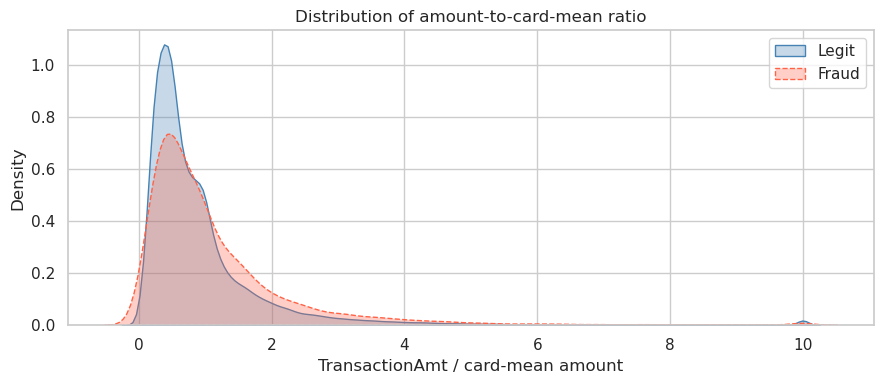

In [13]:
# Visualise: amount vs. card-level mean (fraud vs. legit)
if "card1_TransactionAmt_mean" in X_train.columns:
    plot_df = X_train[["TransactionAmt", "card1_TransactionAmt_mean"]].copy()
    plot_df["ratio"] = plot_df["TransactionAmt"] / (plot_df["card1_TransactionAmt_mean"] + 1)
    plot_df["isFraud"] = y_train.values

    fig, ax = plt.subplots(figsize=(9, 4))
    for label, color, ls in [(0, "steelblue", "-"), (1, "tomato", "--")]:
        data = plot_df.loc[plot_df["isFraud"] == label, "ratio"].clip(0, 10)
        sns.kdeplot(data, ax=ax, color=color, ls=ls,
                    label="Legit" if label == 0 else "Fraud", fill=True, alpha=0.3)
    ax.set_xlabel("TransactionAmt / card-mean amount")
    ax.set_title("Distribution of amount-to-card-mean ratio")
    ax.legend()
    plt.tight_layout()
    plt.show()


## 8. Temporal Feature Engineering

`TransactionDT` is a *seconds offset* from a fixed reference date
(2017-11-30 in the competition data). By mapping it to a calendar,
we extract actionable signals:

- **Hour of day** — fraud spikes at night (00:00–05:59)
- **Day of week** — weekend spending patterns differ
- **Is-weekend, Is-night** — binary fraud indicators

### Cyclical encoding

Naive linear encoding of `hour` treats 23 and 0 as far apart (distance 23),
but they are only 1 hour apart. Cyclical sin/cos encoding maps the feature
onto a unit circle so that 23:00 and 00:00 are close:

```python
sin_hour = sin(2π × hour / 24)
cos_hour = cos(2π × hour / 24)
```


In [14]:
X_train = extract_temporal_features(X_train, col="TransactionDT", cyclical=True)
X_test  = extract_temporal_features(X_test,  col="TransactionDT", cyclical=True)

temporal_cols = ["hour", "day_of_week", "is_weekend", "is_night",
                 "sin_hour", "cos_hour", "tx_age_days"]
temporal_cols = [c for c in temporal_cols if c in X_train.columns]
print(f"Temporal features extracted: {temporal_cols}")


Temporal features extracted: ['hour', 'day_of_week', 'is_weekend', 'is_night', 'sin_hour', 'cos_hour', 'tx_age_days']


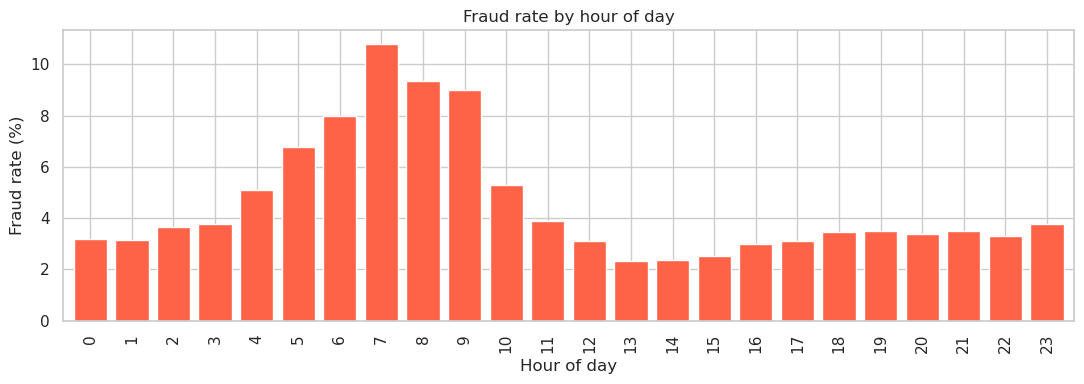

In [15]:
# Fraud rate by hour of day
plot_df = pd.DataFrame({"hour": X_train["hour"], "isFraud": y_train.values})
fraud_by_hour = plot_df.groupby("hour")["isFraud"].mean() * 100

fig, ax = plt.subplots(figsize=(11, 4))
fraud_by_hour.plot(kind="bar", ax=ax, color="tomato", edgecolor="white", width=0.8)
ax.set_xlabel("Hour of day")
ax.set_ylabel("Fraud rate (%)")
ax.set_title("Fraud rate by hour of day")
plt.tight_layout()
plt.show()


In [16]:
# Email-domain derived features
X_train = extract_email_features(X_train)
X_test  = extract_email_features(X_test)

email_feats = [c for c in X_train.columns
               if "email" in c and c not in ["P_emaildomain", "R_emaildomain"]]
print("Email-derived features:", email_feats)
display(X_train[email_feats].head(5))


Email-derived features: ['P_emaildomain_freq', 'R_emaildomain_freq', 'P_emaildomain_te', 'R_emaildomain_te', 'P_emaildomain_TransactionAmt_mean', 'P_emaildomain_TransactionAmt_std', 'P_emaildomain_TransactionAmt_max', 'P_email_tld', 'P_is_privacy_email', 'R_email_tld', 'R_is_privacy_email', 'email_domain_match']


,P_emaildomain_freq,R_emaildomain_freq,P_emaildomain_te,R_emaildomain_te,P_emaildomain_TransactionAmt_mean,P_emaildomain_TransactionAmt_std,P_emaildomain_TransactionAmt_max,P_email_tld,P_is_privacy_email,R_email_tld,R_is_privacy_email,email_domain_match
0,0.0630,0.0349,0.0285,0.0148,169.7109,269.1929,4843.7500,com,1,com,1,1
1,0.3865,0.7667,0.0387,0.0338,128.6291,227.5566,5420.0000,com,0,Unknown,0,0
2,0.0132,0.7667,-0.0036,0.0031,197.6015,308.3893,4146.6602,net,0,Unknown,0,0
3,0.1600,0.7667,NaN,NaN,119.1766,191.4564,5278.9502,Unknown,0,Unknown,0,1
4,0.1600,0.7667,0.0159,0.0055,119.1766,191.4564,5278.9502,Unknown,0,Unknown,0,1


## 9. PCA Compression of V-Feature Blocks

The 339 V-features (V1–V339) were engineered by Vesta Corporation and
grouped into correlated blocks with shared missingness patterns.
Including all 339 raw columns has two problems:

1. **High dimensionality** — many columns are nearly collinear.
2. **Missing-value blocks** — an entire block may be -999 for a given row.

**Strategy:** apply PCA *per block*, retaining 95 % of explained variance.
This typically compresses 50–100 columns to 5–15 components while preserving
the signal.


In [17]:
# Define V-feature blocks (mirrors the missingness structure)
V_BLOCKS = {
    "v_blk1":  [f"V{i}" for i in range(1,   12)],
    "v_blk2":  [f"V{i}" for i in range(12,  35)],
    "v_blk3":  [f"V{i}" for i in range(35,  53)],
    "v_blk4":  [f"V{i}" for i in range(53,  75)],
    "v_blk5":  [f"V{i}" for i in range(75,  95)],
    "v_blk6":  [f"V{i}" for i in range(95,  138)],
    "v_blk7":  [f"V{i}" for i in range(138, 167)],
    "v_blk8":  [f"V{i}" for i in range(167, 217)],
    "v_blk9":  [f"V{i}" for i in range(217, 279)],
    "v_blk10": [f"V{i}" for i in range(279, 340)],
}

pca_objects = {}
for block_name, v_cols in V_BLOCKS.items():
    present = [c for c in v_cols if c in X_train.columns]
    if len(present) < 2:
        continue
    X_train, pca_obj = pca_compress(
        X_train, cols=present, n_components=0.95,
        prefix=block_name, fit_df=X_train,
    )
    X_test, _ = pca_compress(
        X_test, cols=present, n_components=pca_obj.n_components_,
        prefix=block_name, fit_df=None, pca=pca_obj,
    )
    # For test we need to apply the already-fitted PCA
    # (pca_compress with int n_components and fit_df=None won't refit)
    pca_objects[block_name] = pca_obj

print(f"\nShape after PCA compression: {X_train.shape}")


PCA: 11 cols → 1 components (100.0 % variance retained).
PCA: 11 cols → 1 components (100.0 % variance retained).
PCA: 23 cols → 1 components (100.0 % variance retained).
PCA: 23 cols → 1 components (100.0 % variance retained).
PCA: 18 cols → 1 components (100.0 % variance retained).
PCA: 18 cols → 1 components (100.0 % variance retained).
PCA: 22 cols → 1 components (100.0 % variance retained).
PCA: 22 cols → 1 components (100.0 % variance retained).
PCA: 20 cols → 1 components (100.0 % variance retained).
PCA: 20 cols → 1 components (100.0 % variance retained).
PCA: 43 cols → 1 components (97.0 % variance retained).
PCA: 43 cols → 1 components (97.0 % variance retained).
PCA: 29 cols → 1 components (99.4 % variance retained).
PCA: 29 cols → 1 components (99.4 % variance retained).
PCA: 50 cols → 2 components (95.3 % variance retained).
PCA: 50 cols → 2 components (95.3 % variance retained).
PCA: 62 cols → 3 components (95.7 % variance retained).
PCA: 62 cols → 3 components (95.7 % va

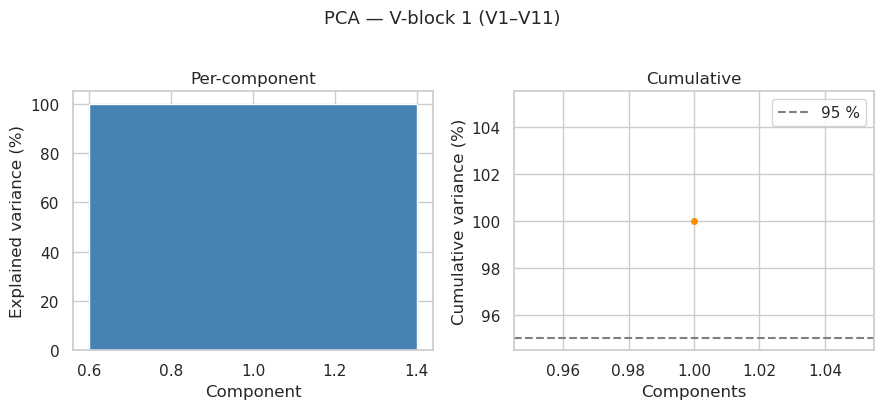

In [18]:
# Visualise explained variance for one block
if "v_blk1" in pca_objects:
    plot_pca_explained_variance(pca_objects["v_blk1"],
                                title="PCA — V-block 1 (V1–V11)")


## 10. Feature Selection

With hundreds of engineered features, removing redundant ones:
- Speeds up training
- Reduces overfitting (especially for linear models)
- Improves interpretability

We apply three complementary filters in sequence:

1. **Variance threshold** — drop near-constant features (zero variance).
2. **Correlation pruning** — drop one of each highly-correlated pair (|ρ| > 0.95).
3. **Permutation importance** — keep the top-N most predictive features.


In [19]:
# Only keep numeric columns for the selection steps
X_train_num = X_train.select_dtypes(include=[np.number])
X_test_num  = X_test[X_train_num.columns]

print(f"Starting features: {X_train_num.shape[1]}")

# Step 1: Variance threshold
X_train_num = variance_threshold_select(X_train_num, threshold=0.0,
                                        exclude=["isFraud"])
X_test_num  = X_test_num[X_train_num.columns]
print(f"After variance filter: {X_train_num.shape[1]}")

# Step 2: Correlation pruning
print("\nCorrelation pruning (|ρ| > 0.95):")
X_train_num = drop_high_correlation(X_train_num, threshold=0.95, verbose=True)
X_test_num  = X_test_num[X_train_num.columns]
print(f"After correlation filter: {X_train_num.shape[1]}")


Starting features: 141
Variance threshold: dropped 0 features.
After variance filter: 141

Correlation pruning (|ρ| > 0.95):
  Dropping 'addr2' (|ρ| = 0.973 with 'addr1')
  Dropping 'C2' (|ρ| = 0.995 with 'C1')
  Dropping 'C4' (|ρ| = 0.967 with 'C1')
  Dropping 'C6' (|ρ| = 0.982 with 'C1')
  Dropping 'C8' (|ρ| = 0.967 with 'C1')
  Dropping 'C8' (|ρ| = 0.983 with 'C7')
  Dropping 'C10' (|ρ| = 0.957 with 'C1')
  Dropping 'C10' (|ρ| = 0.985 with 'C7')
  Dropping 'C11' (|ρ| = 0.996 with 'C1')
  Dropping 'C12' (|ρ| = 0.999 with 'C7')
  Dropping 'C14' (|ρ| = 0.951 with 'C1')
  Dropping 'D9' (|ρ| = 0.977 with 'D8')
  Dropping 'id_04' (|ρ| = 1.000 with 'id_03')
  Dropping 'id_05' (|ρ| = 0.966 with 'id_01')
  Dropping 'id_06' (|ρ| = 0.966 with 'id_01')
  Dropping 'id_08' (|ρ| = 1.000 with 'id_07')
  Dropping 'id_09' (|ρ| = 0.977 with 'D8')
  Dropping 'id_10' (|ρ| = 0.977 with 'D8')
  Dropping 'id_11' (|ρ| = 0.985 with 'id_01')
  Dropping 'id_17' (|ρ| = 0.978 with 'id_01')
  Dropping 'id_19' (|ρ

After importance filter (top 60): 60


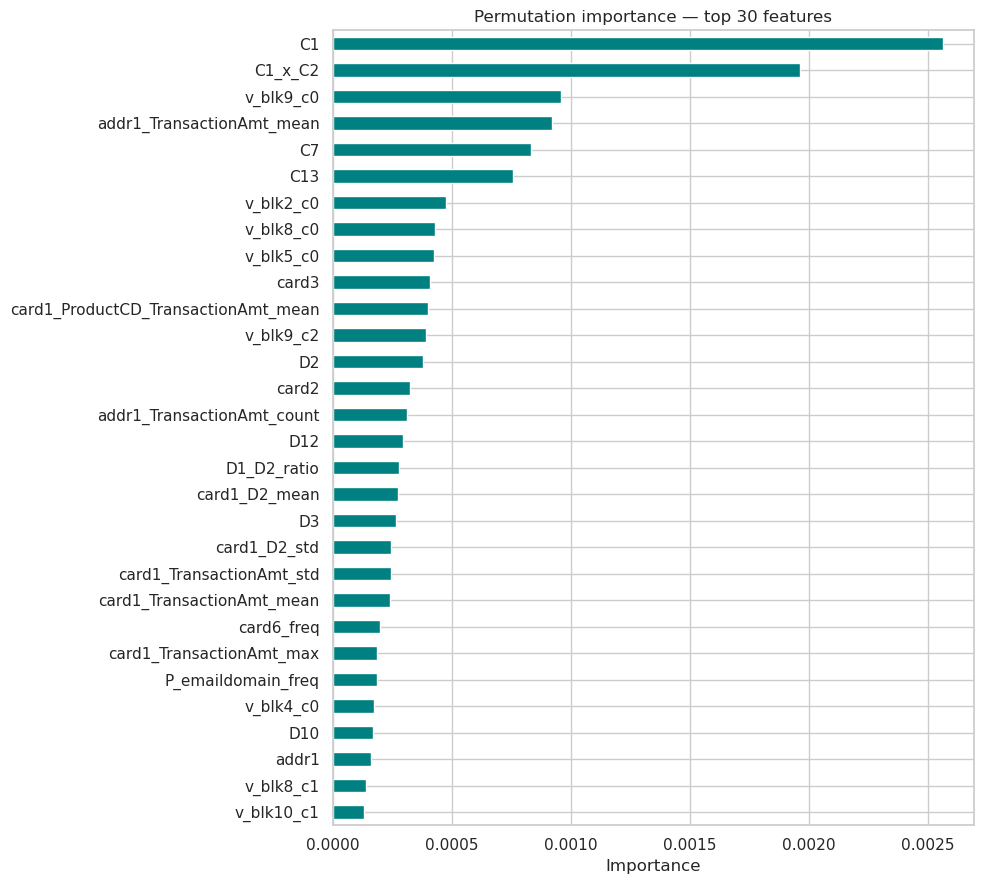

In [20]:
# Step 3: Permutation importance with a fast RF
from sklearn.ensemble import RandomForestClassifier

rf_selector = RandomForestClassifier(
    n_estimators=100, max_depth=8, n_jobs=-1, random_state=42
)
rf_selector.fit(X_train_num, y_train)

X_train_selected, imp_series = importance_select(
    X_train_num, y_train, model=rf_selector, top_n=60,
)
X_test_selected = X_test_num[X_train_selected.columns]

print(f"After importance filter (top 60): {X_train_selected.shape[1]}")

plot_feature_importance(
    imp_series, top_n=30,
    title="Permutation importance — top 30 features",
    figsize=(10, 9),
)


## 11. Baseline vs. Engineered Features — Model Lift

We compare two XGBoost classifiers:

- **Baseline** — raw numeric columns only, minimal preprocessing.
- **Engineered** — full feature set built in §§3–10.

This quantifies the value-add of feature engineering beyond raw data.


In [21]:
# ── Baseline: raw transaction columns only ────────────────────────────────────
BASELINE_COLS = (
    ["TransactionAmt", "TransactionDT"]
    + [f"card{i}" for i in range(1, 7)]
    + [f"C{i}" for i in range(1, 15)]
    + [f"D{i}" for i in range(1, 16)]
)

# Load fresh (un-engineered) splits
X_raw = df.drop(columns=["isFraud", "TransactionID"])
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(
    X_raw, df["isFraud"], test_size=0.20, random_state=42, stratify=df["isFraud"]
)

base_cols_present = [c for c in BASELINE_COLS
                     if c in X_raw_train.select_dtypes(include=np.number).columns]
X_base_train = X_raw_train[base_cols_present].fillna(-999)
X_base_test  = X_raw_test[base_cols_present].fillna(-999)

print(f"Baseline feature count : {X_base_train.shape[1]}")
print(f"Engineered feature count: {X_train_selected.shape[1]}")


Baseline feature count : 35
Engineered feature count: 60


In [22]:
xgb_params = dict(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
    eval_metric="auc",
    n_jobs=-1,
)

# Baseline model
xgb_base = XGBClassifier(**xgb_params)
xgb_base.fit(X_base_train, y_raw_train)

# Engineered-features model
xgb_eng = XGBClassifier(**xgb_params)
xgb_eng.fit(X_train_selected, y_train)

print("Training complete.")


Training complete.


In [23]:
results_base = evaluate_model(
    xgb_base, X_base_train, y_raw_train,
    X_base_test,  y_raw_test,
    name="XGBoost — Baseline features",
)

results_eng = evaluate_model(
    xgb_eng, X_train_selected, y_train,
    X_test_selected, y_test,
    name="XGBoost — Engineered features",
)

lift = results_eng["test_auc"] - results_base["test_auc"]
print(f"\n>>> AUC lift from feature engineering: {lift:+.4f}")



  XGBoost — Baseline features
  Train AUC-ROC : 0.9501
  Test  AUC-ROC : 0.9304
  Test  Avg Prec: 0.6076

              precision    recall  f1-score   support

           0     0.9925    0.8939    0.9406    113975
           1     0.2178    0.8149    0.3438      4133

    accuracy                         0.8911    118108
   macro avg     0.6052    0.8544    0.6422    118108
weighted avg     0.9654    0.8911    0.9198    118108


  XGBoost — Engineered features
  Train AUC-ROC : 0.9606
  Test  AUC-ROC : 0.9432
  Test  Avg Prec: 0.6384

              precision    recall  f1-score   support

           0     0.9931    0.9079    0.9486    113975
           1     0.2455    0.8260    0.3785      4133

    accuracy                         0.9051    118108
   macro avg     0.6193    0.8670    0.6636    118108
weighted avg     0.9669    0.9051    0.9287    118108


>>> AUC lift from feature engineering: +0.0128


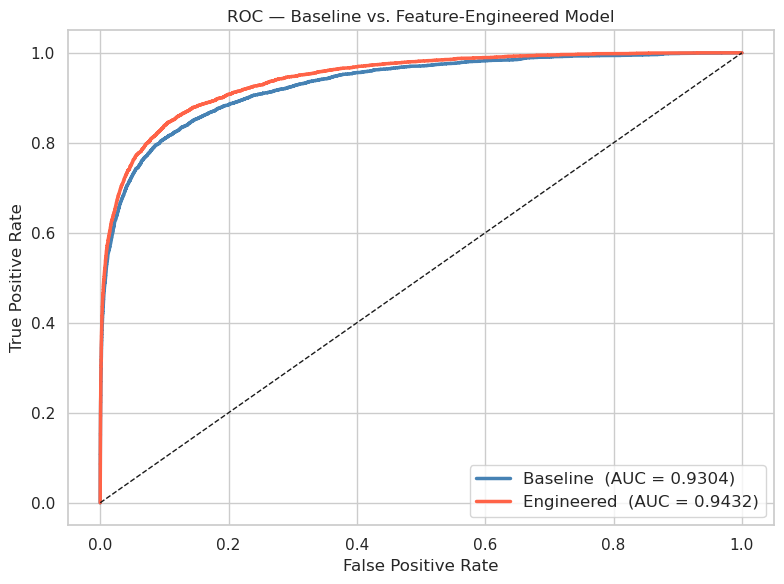

In [24]:
# ROC comparison (handles different feature sets per model)
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(8, 6))
pairs = [
    (xgb_base, X_base_test,      y_raw_test, "Baseline",   "steelblue"),
    (xgb_eng,  X_test_selected,  y_test,     "Engineered", "tomato"),
]
for model, X_t, y_t, label, color in pairs:
    proba = model.predict_proba(X_t)[:, 1]
    fpr, tpr, _ = roc_curve(y_t, proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2.5,
            label=f"{label}  (AUC = {roc_auc:.4f})")

ax.plot([0, 1], [0, 1], "k--", lw=1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC — Baseline vs. Feature-Engineered Model")
ax.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()


## 12. Summary & Best-Practice Checklist

The table below distils the key lessons from this notebook.

| Practice | Implementation | Why it matters |
|----------|----------------|----------------|
| **Fit-on-train-only** | All encoders, scalers, and aggregators fitted exclusively on `X_train` | Prevents target leakage |
| **Sentinel imputation** | `-999` fill for trees; median + `_was_nan` for linear models | Lets trees learn missingness as a signal |
| **Smoothed target encoding** | `TargetEncoder(smoothing=20)` with LOO | Avoids overfitting on rare categories |
| **Frequency encoding** | `FrequencyEncoder` | Captures category prevalence without leakage |
| **Group aggregations** | `GroupAggregator` | Encodes entity-level behaviour |
| **Cyclical temporals** | `sin/cos` pairs for hour, day-of-week, month | Distances are meaningful for periodic features |
| **PCA per V-block** | `pca_compress` per block | Removes collinearity; respects missingness structure |
| **Correlation pruning** | `drop_high_correlation(threshold=0.95)` | Removes redundancy without harming signal |
| **Permutation importance** | `importance_select(top_n=60)` | Model-agnostic, avoids bias toward high-cardinality |
| **`scale_pos_weight`** | Inverse class-frequency ratio | Handles 3.5 % fraud imbalance |
| **Memory optimisation** | `reduce_mem_usage` | Essential for 590 k × 394 column data |

### Next steps (not covered here)
- **Time-aware cross-validation** — `TimeSeriesSplit` to simulate production conditions.
- **Target-encoded features in CV** — use `cross_val_predict` with target encoder inside each fold.
- **UMAP / t-SNE** — unsupervised exploration of the V-feature latent space.
- **Neural entity embeddings** — learn card and email embeddings end-to-end.
